# [Module 3.0] Fine-Tuning a BERT Model and Create a Text Classifier

이 노트북은 레이블의 수(5개 --> 10개)를 제외하고 아래 참조의 노트북을 재실행을 함. 
아래와 같은 작업을 진행 함

- TF에 입력할 Data Builder 정의
- Train, Validation, Test Dataset 생성
- Pre-trained BERT with classification layer on top 를 로딩시에 에 10개의 레이블 정보를 제공
- Train 데이타를 가지고 학습 및 모델 저장
- 저장된 모엘을 Reload를 해서 Test 데이타를 추론 함
- Accuracy 및 Confusion Matrix를 생성

---
이 노트북은 약 3분 정도 소요 됩니다.

---
Reference
- Fine-Tuning a BERT Model and Create a Text Classifier
- https://github.com/data-science-on-aws/workshop/blob/master/07_train/01_Train_Reviews_BERT_Transformers_TensorFlow_AdHoc.ipynb

In [1]:
!pip install --upgrade pip
!pip install -q wrapt --upgrade --ignore-installed
!pip install -q tensorflow==2.1.0
!pip install -q transformers==2.8.0

Requirement already up-to-date: pip in /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages (20.2.2)
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

astroid 2.3.3 requires wrapt==1.11.*, but you'll have wrapt 1.12.1 which is incompatible.


In [2]:
import time
import random
import pandas as pd
from glob import glob
import argparse
import json
import subprocess
import sys
import os
import tensorflow as tf
from transformers import DistilBertTokenizer
from transformers import TFDistilBertForSequenceClassification
from transformers import TextClassificationPipeline
from transformers.configuration_distilbert import DistilBertConfig

In [3]:
tf.__version__

'2.1.0'

### Parameter

In [4]:

EPOCHS = 1
steps = 10
STEPS_PER_EPOCH= steps
VALIDATION_STEPS= steps
TEST_STEPS= steps

# VALIDATION_STEPS= int(steps / 2)
# TEST_STEPS= int(steps / 2)

learning_rate = 4e-5
BATCH_SIZE= 128


MAX_SEQ_LENGTH= 32
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
NUM_GPUS=0

## 학습 데이터 셋 생성위한 함수 (TF 위한 Data Builder)

In [5]:
def select_data_and_label_from_record(record):
    x = {
        'input_ids': record['input_ids'],
        'input_mask': record['input_mask'],
        'segment_ids': record['segment_ids']
    }
    y = record['label_ids']

    return (x, y)

In [6]:
def file_based_input_dataset_builder(channel,
                                     input_filenames,
                                     pipe_mode,
                                     is_training,
                                     drop_remainder):

    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    if pipe_mode:
        print('***** Using pipe_mode with channel {}'.format(channel))
        from sagemaker_tensorflow import PipeModeDataset
        dataset = PipeModeDataset(channel=channel,
                                  record_format='TFRecord')
    else:
        print('***** Using input_filenames {}'.format(input_filenames))
        dataset = tf.data.TFRecordDataset(input_filenames)

    dataset = dataset.repeat(EPOCHS * STEPS_PER_EPOCH)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
      "input_ids": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "input_mask": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "segment_ids": tf.io.FixedLenFeature([MAX_SEQ_LENGTH], tf.int64),
      "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)
        
    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
          lambda record: _decode_record(record, name_to_features),
          batch_size=BATCH_SIZE,
          drop_remainder=drop_remainder,
          num_parallel_calls=tf.data.experimental.AUTOTUNE))

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42,
                                  buffer_size=10,
                                  reshuffle_each_iteration=True)

    return dataset

In [7]:
train_data = 'data/output/bert/train'

## Train, Validation, Test Dataset 생성

두 개의 TF Record 파일을 가지고 Train Dataset을 생성

In [8]:
train_data_filenames = glob('{}/*.tfrecord'.format(train_data))
print('train_data_filenames {}'.format(train_data_filenames))
train_dataset = file_based_input_dataset_builder(
    channel = 'train',
    input_filenames = train_data_filenames,
    pipe_mode=False,
    is_training=True,
    drop_remainder=False).map(select_data_and_label_from_record)

train_data_filenames ['data/output/bert/train/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/train/part-unknown-tweet_file_02.tfrecord']
***** Using input_filenames ['data/output/bert/train/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/train/part-unknown-tweet_file_02.tfrecord']
Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [9]:
train_dataset

<MapDataset shapes: ({input_ids: (None, 32), input_mask: (None, 32), segment_ids: (None, 32)}, (None,)), types: ({input_ids: tf.int64, input_mask: tf.int64, segment_ids: tf.int64}, tf.int64)>

In [10]:
len(list(train_dataset))

60

In [11]:
validation_data = 'data/output/bert/validation'

In [12]:
validation_data_filenames = glob('{}/*.tfrecord'.format(validation_data))

print('validation_data_filenames {}'.format(validation_data_filenames))
validation_dataset = file_based_input_dataset_builder(
    channel='validation',
    input_filenames=validation_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

validation_data_filenames ['data/output/bert/validation/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/validation/part-unknown-tweet_file_02.tfrecord']
***** Using input_filenames ['data/output/bert/validation/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/validation/part-unknown-tweet_file_02.tfrecord']


In [13]:
test_data = 'data/output/bert/test'

In [14]:
test_data_filenames = glob('{}/*.tfrecord'.format(test_data))

print(test_data_filenames)

test_dataset = file_based_input_dataset_builder(
    channel='test',
    input_filenames=test_data_filenames,
    pipe_mode=False,
    is_training=False,
    drop_remainder=False).map(select_data_and_label_from_record)

['data/output/bert/test/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/test/part-unknown-tweet_file_02.tfrecord']
***** Using input_filenames ['data/output/bert/test/part-unknown-tweet_file_01.tfrecord', 'data/output/bert/test/part-unknown-tweet_file_02.tfrecord']


## Pre-trained BERT Model 에 10개의 레이블 제공
- TFDistilBertForSequenceClassification 는 BERT Layer에 Classification Layer를 가지고 있음

참조: TFDistilBertForSequenceClassification
- https://huggingface.co/transformers/model_doc/distilbert.html#tfdistilbertforsequenceclassification

In [15]:
config = DistilBertConfig.from_pretrained('distilbert-base-uncased',
                                          num_labels = len(CLASSES)
                                         )
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config = config)

In [16]:
# config

## Setup the Custom Classifier Model 
Pre-trained 모델 정의를 변경 함 

- TFDistilBertForSequenceClassification는 tf.keras.Model의 sub-class 임
- BERT Layer만을 Freezing을 시키고 학습

In [17]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

optimizer = tf.keras.optimizers.Adam(learning_rate= learning_rate, epsilon=1e-08)
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])
model.layers[0].trainable = False # BERT Layer를 Freezing
model.summary()

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  7690      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,961,162
Trainable params: 598,282
Non-trainable params: 66,362,880
_________________________________________________________________


In [18]:
callbacks = []

log_dir = './tensorboard/'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callbacks.append(tensorboard_callback)

In [19]:
history = model.fit(train_dataset,
                    shuffle=True,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=validation_dataset,
                    validation_steps=VALIDATION_STEPS,
                    callbacks=callbacks)

Train for 10 steps, validate for 10 steps
10/10 [==============================] - 18s 2s/step - loss: 2.2991 - accuracy: 0.1180 - val_loss: 0.9229 - val_accuracy: 0.1818


In [20]:
# history.history.keys.

In [21]:
print('Trained model {}'.format(model))

Trained model <transformers.modeling_tf_distilbert.TFDistilBertForSequenceClassification object at 0x7f6dc83e1c88>


## Evaluate on Holdout Test Dataset

In [22]:
test_history = model.evaluate(test_dataset, steps=TEST_STEPS, callbacks = callbacks)
print(test_history)

 4/10 [===========>..................] - ETA: 4s - loss: 2.3369 - accuracy: 0.0909WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10 batches). You may need to use the repeat() function when building your dataset.
[0.9347780704498291, 0.09090909]


## Save the Model

In [23]:
model_dir = './fine-tuned'

In [24]:
!mkdir -p $model_dir
model.save_pretrained(model_dir)

In [25]:
!ls -al $model_dir

total 261708
drwxrwxr-x  2 ec2-user ec2-user      4096 Aug 17 09:47 .
drwxrwxr-x 12 ec2-user ec2-user      4096 Aug 17 09:47 ..
-rw-rw-r--  1 ec2-user ec2-user      1549 Aug 17 09:48 config.json
-rw-rw-r--  1 ec2-user ec2-user 267974448 Aug 17 09:48 tf_model.h5


In [26]:
# cat $model_dir/config.json

## 학습된 모델을 Loading

In [27]:
import json
from transformers import TFDistilBertForSequenceClassification

loaded_model = TFDistilBertForSequenceClassification.from_pretrained(model_dir,
                                                                     id2label={
                                                                       0: 0,
                                                                       1: 1,
                                                                       2: 2,
                                                                       3: 3,
                                                                       4: 4,
                                                                       5: 5,
                                                                       6: 6,
                                                                       7: 7,
                                                                       8: 8,
                                                                       9: 9                                                                         
                                                                     },
                                                                     label2id={
                                                                       0: 0,
                                                                       1: 1,
                                                                       2: 2,
                                                                       3: 3,
                                                                       4: 4,
                                                                       5: 5,
                                                                       6: 6,
                                                                       7: 7,
                                                                       8: 8,
                                                                       9: 9                                                                         
                                                                    })

In [28]:
loaded_model

In [29]:
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

if NUM_GPUS >= 1:
    inference_device = 0 # GPU 0
else:
    inference_device = -1 # CPU
print('inference_device {}'.format(inference_device))    

inference_device -1


In [30]:
from transformers import TextClassificationPipeline
inference_pipeline = TextClassificationPipeline(model = loaded_model,
                                                tokenizer = tokenizer,
                                                framework = 'tf',
                                                device = inference_device) # -1 is CPU, 0 is GPU

In [31]:
print("""I loved it!  I will recommend this to everyone.""", inference_pipeline("""I loved it!  I will recommend this to everyone."""))
print("""Really bad.  I hope they don't make this anymore.""", inference_pipeline("""Really bad.  I hope they don't make this anymore."""))

I loved it!  I will recommend this to everyone. [{'label': 8, 'score': 0.11847665}]
Really bad.  I hope they don't make this anymore. [{'label': 8, 'score': 0.1158876}]


## Test Model

In [32]:
train_gz_file = 'data/split/tweet_file_01.csv.gz'

In [33]:
import csv

df_sample_reviews = pd.read_csv(train_gz_file, 
                                compression='gzip')[['TWEET', 'LABEL']].sample(n=100)
print(df_sample_reviews.shape)
print(df_sample_reviews.head())


(100, 2)
                                                   TWEET  LABEL
15964                      this boy go crazy about pizza      3
27553  supposed to be quitting work today but need st...      9
33572                                          lol yinkz      3
40964      ayyyye i had just purchased two how to books       4
6140                           who on rville can do this      3


In [34]:
import pandas as pd

def predict(review_body):
    prediction_map = inference_pipeline(review_body)
    return prediction_map[0]['label']

y_pred = df_sample_reviews['TWEET'].map(predict)
y_pred

15964    8
27553    3
33572    8
40964    8
6140     8
        ..
16573    8
29282    8
16694    8
22942    8
25276    3
Name: TWEET, Length: 100, dtype: int64

In [35]:
y_pred.value_counts()

8    86
3    14
Name: TWEET, dtype: int64

In [36]:
y_true = df_sample_reviews['LABEL']
y_true

15964    3
27553    9
33572    3
40964    4
6140     3
        ..
16573    7
29282    8
16694    3
22942    6
25276    9
Name: LABEL, Length: 100, dtype: int64

## Classification Report

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_true=y_true, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00         5
           3       0.21      0.21      0.21        14
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00        13
           7       0.00      0.00      0.00         6
           8       0.12      0.83      0.20        12
           9       0.00      0.00      0.00         9

    accuracy                           0.13       100
   macro avg       0.03      0.10      0.04       100
weighted avg       0.04      0.13      0.05       100



/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Accuracy

In [38]:
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_pred=y_pred, y_true=y_true))

Accuracy:  0.13


## Confusion Matrix

In [39]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

def plot_conf_mat(cm, classes, title, cmap = plt.cm.Greens):
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
        horizontalalignment="center",
        color="black" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

[[ 0  0  0  1  0  0  0  0  9  0]
 [ 0  0  0  0  0  0  0  0 14  0]
 [ 0  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  3  0  0  0  0 11  0]
 [ 0  0  0  1  0  0  0  0  7  0]
 [ 0  0  0  3  0  0  0  0  6  0]
 [ 0  0  0  2  0  0  0  0 11  0]
 [ 0  0  0  0  0  0  0  0  6  0]
 [ 0  0  0  2  0  0  0  0 10  0]
 [ 0  0  0  2  0  0  0  0  7  0]]


<Figure size 432x288 with 0 Axes>

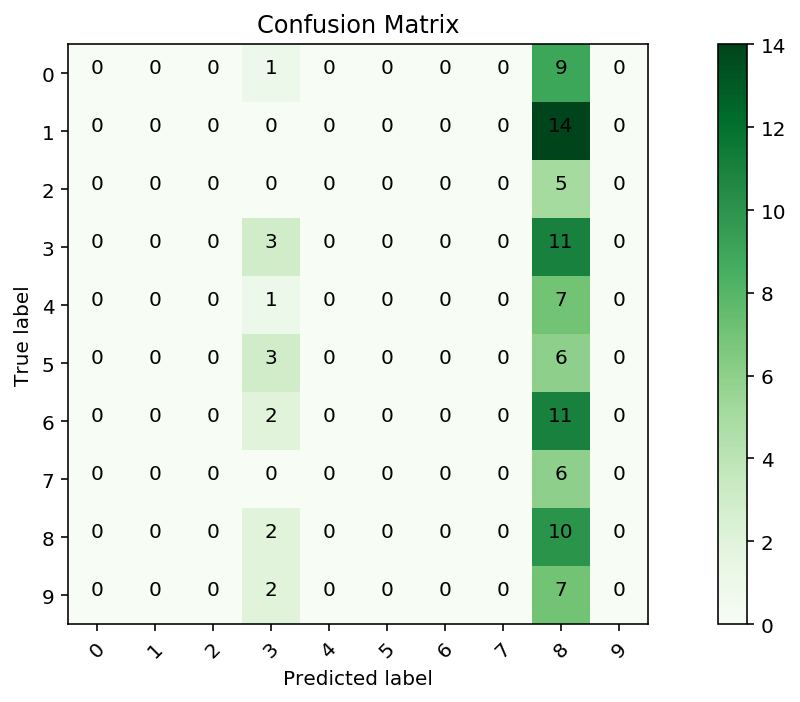

In [40]:
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true=y_true, y_pred=y_pred)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4', '5','6','7','8','9'], 
              title='Confusion Matrix')
plt.show()